# DE genes in time
Differential expression of genes through time in mutants vs AX4.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import seaborn as sb

import deR.stages_library as sl
reload(sl)
from deR.stages_library import *


In [2]:
path = '/home/karin/Documents/timeTrajectories/data/deTime/de_time_impulse/'

In [3]:
dataPath = '/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [4]:
# Replace low p values with MINP so that they are not -inf after log transform for plotting
MINP = 10 ** -323.6

## FDR threshold choise
Select FDR treshold bvased on found DE between AX4 sample groups (FD, PE, SE). It is expected that majority of DE genes between these groups do not represent important biological differences - they happen due to biological and technical noise and thus have lower scale/FDR. A threshold could be selected to filter out most De genes between AX4 groups. 

In [7]:
# Replace low p values with MINP so that they are not -inf after log transform for plotting
files = [f for f in glob.glob(path + "DE_*padj0.05.tsv")]
files.sort()
padj_dict = dict()
for f in files:
    data = pd.read_table(f)
    name = f.split('DE_')[1].split('_t')[0]
    padjs = data['padj'].values
    padjs[padjs < MINP] = MINP
    padj_dict[name] = data['padj'].values

In [8]:
refs = ['AX4_PE_ref_AX4_FD', 'AX4_PE_ref_AX4_SE', 'AX4_SE_ref_AX4_FD']

### FDR distribution

Distribution of FDR (filtered to be above 0.05) when making diferent comparisons (e. g. comH_ref_AX4 compares comH against reference AX4). 

Text(0, 0.5, 'log10(padj)')

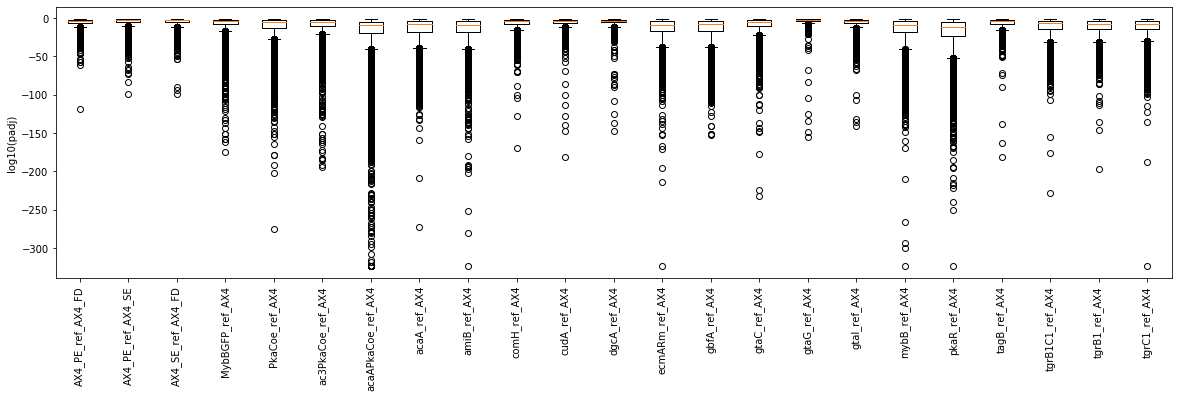

In [9]:
names = list(padj_dict.keys())
padjs = [np.log10(padj_list) for padj_list in padj_dict.values()]
fig, ax = plt.subplots(figsize=(20,5))
plt.boxplot(padjs)
ax.set_xticklabels(names, rotation=90, fontsize=10)
plt.ylabel('log10(padj)')


In [10]:
thresholds={-5:'orange',-11:'green'}

Threshold -5 is marked with orange
Threshold -11 is marked with green


(-80, -1)

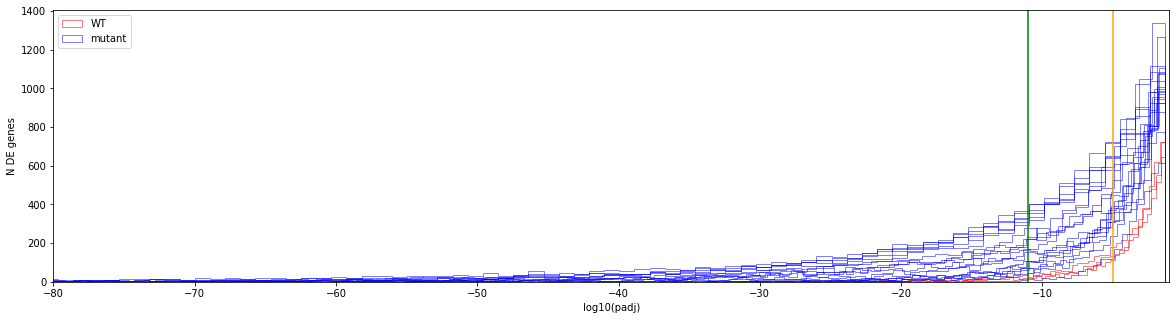

In [11]:
fig1, ax1 = plt.subplots(figsize=(20,5))
for name, padjs in padj_dict.items():
    padjs = np.log10(padjs)
    if name in refs:
        colour = 'r'
        name='WT'
    else:
        colour = 'b'
        name='mutant'
    ax1.hist(padjs, bins=300, histtype='step', fill=None, alpha=0.5,  label=name, color=colour)
ax1.legend()
handles, labels = fig1.gca().get_legend_handles_labels()
by_label =dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())
ax1.set_xlabel('log10(padj)')
ax1.set_ylabel('N DE genes')
for threshold,colour in thresholds.items():
    ax1.axvline(threshold,color=colour)
    print('Threshold',threshold, 'is marked with',colour)
ax1.set_xlim(left=-80,right=-1)


N genes marked as DE based on selected FDR for each group. 

In [12]:
retained_n=pd.DataFrame()
for name, padjs in padj_dict.items():
    for threshold in thresholds.keys():
        retained_n.loc[name,'N DE 10^'+str(threshold)]=len(padjs[padjs<=10**threshold])
retained_n.astype('int').sort_values(retained_n.columns[0])

,N DE 10^-5,N DE 10^-11
gtaG_ref_AX4,636,72
AX4_PE_ref_AX4_SE,1251,336
AX4_SE_ref_AX4_FD,1624,451
AX4_PE_ref_AX4_FD,1738,451
dgcA_ref_AX4,1805,431
cudA_ref_AX4,2258,552
gtaI_ref_AX4,2491,725
tagB_ref_AX4,2601,836
comH_ref_AX4,3024,986
MybBGFP_ref_AX4,3101,1120


gtaG has unexpectedly low number of DE genes (less than when comparing two groups of AX4 samples to each other). pkaR has the most DE genes; it also had distiburion of similarities to the closest neighbour shifted towards higher similarities, compared to other strains with same number of measurments.

## Comparison of DE genes between groups
Comparison of DE gene sets across strains at different FDRs. Hierarchical clustering is uses distances based on hypergeometric test p values for group overlap. 

In [13]:
def plot_de_hc(files, fdr):
    de_dict = dict()
    for f in files:
        name = f.split('DE_')[1].split('_t')[0]
        data = pd.read_table(f)
        de_genes=set(data.loc[data['padj']<=fdr,'Gene'].values)
        de_dict[name.split('_')[0]] = de_genes
    plot_genegroup_similarity(de_dict, splitby='Strain',  jaccard_or_p=False,n_all_genes=NGENES,
                              group_colours=GROUP_COLOURS,add_title=', FDR 10^'+str(threshold))
    return de_dict

In [14]:
NGENES=12431 #From networks/selected_genes.ipynb
GROUP_COLOURS={
    'amiB':'#295287','mybB':'#295287','acaA':'#295287','gtaC':'#295287',
    'gbfA':'#4b9a9c','tgrC1':'#4b9a9c','tgrB1':'#4b9a9c','tgrB1C1':'#4b9a9c',
    'tagB':'#51914a','comH':'#51914a',
    'ecmARm':'#939c48','gtaI':'#939c48','cudA':'#939c48','dgcA':'#939c48','gtaG':'#939c48',
    'AX4':'#ad7836','MybBGFP':'#ad7836',
    'acaAPkaCoe':'#ad3a36','ac3PkaCoe':'#ad3a36',
    'pkaR':'#ad4994','PkaCoe':'#ad4994',
    'all':'#919091'
}

In [15]:
# Select genes DE at the selected threshold
files = [f for f in glob.glob(path + "DE_*tsv") if f.count('AX4')==1]


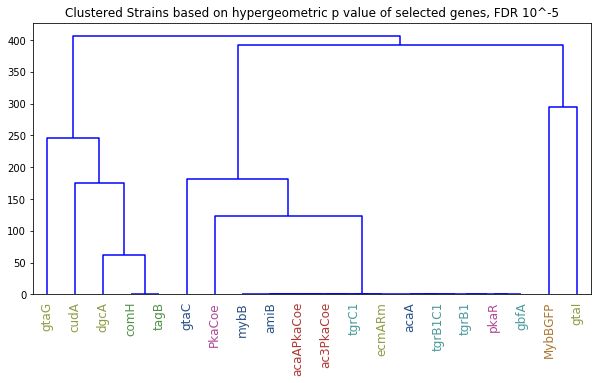

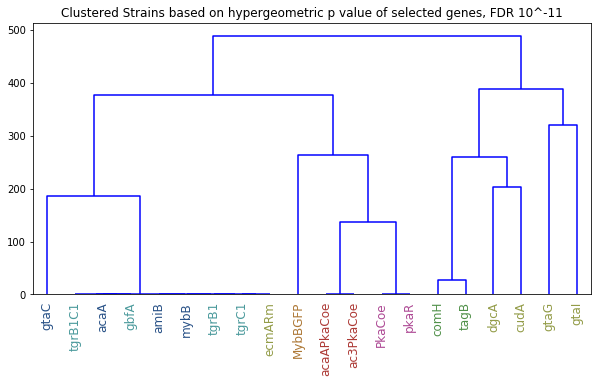

In [16]:
de_dicts=dict()
for threshold in thresholds.keys():
    de_dicts[threshold]=plot_de_hc(files, 10**(threshold))

In [17]:
de_table=gene_heatmap(genes=genes,genes_dict=de_dicts[-11])

In [18]:
by_group_avg=group_gene_heatmap(genes_df=de_table,mode='average')
by_group_avg=by_group_avg.rename({row:row+'_DE' for row in by_group_avg.index})
by_group=group_gene_heatmap(genes_df=de_table,mode='sum')
by_group=by_group.rename({row:row+'_DE' for row in by_group.index})

In [19]:
by_group_avg.to_csv(path+'DE_FDRe'+str(-11)+'group_avg.tsv',sep='\t')
by_group.to_csv(path+'DE_FDRe'+str(-11)+'group.tsv',sep='\t')